## 1. 사용할 패키지 불러오기

In [350]:
import cv2
import tqdm
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from librosa.feature import melspectrogram
import librosa
import librosa.display


## 2. 데이터 불러오기

In [2]:
ok_files = os.listdir("data/OK")
ng_files = os.listdir("data/NG")

## 3. 데이터 EDA

### (1) Class 분포 관찰

In [3]:
Class_num_df = pd.DataFrame({"Class": ["OK", "NG"], "Count": [len(ok_files), len(ng_files)]})
Class_num_df

,Class,Count
0,OK,6521
1,NG,1875


/tmp/ipykernel_25205/3835949367.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=Class_num_df, palette='seismic')


<Axes: xlabel='Class', ylabel='Count'>

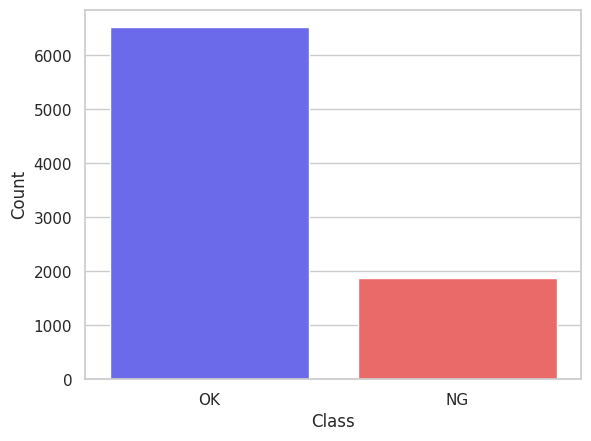

In [4]:
sns.set_theme(style="whitegrid")
sns.barplot(x="Class", y="Count", data=Class_num_df, palette='seismic')

### (2) Class 별 시계열 트렌드

#### - Guitar

In [5]:
ok_signal, _ = librosa.load("data/OK/normal_id_00_00000000.wav", 16000)
ng_signal, _ = librosa.load("data/NG/anomaly_id_00_00000000.wav", 16000)

/tmp/ipykernel_25205/167254775.py:1: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ok_signal, _ = librosa.load("data/OK/normal_id_00_00000000.wav", 16000)
/tmp/ipykernel_25205/167254775.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ng_signal, _ = librosa.load("data/NG/anomaly_id_00_00000000.wav", 16000)


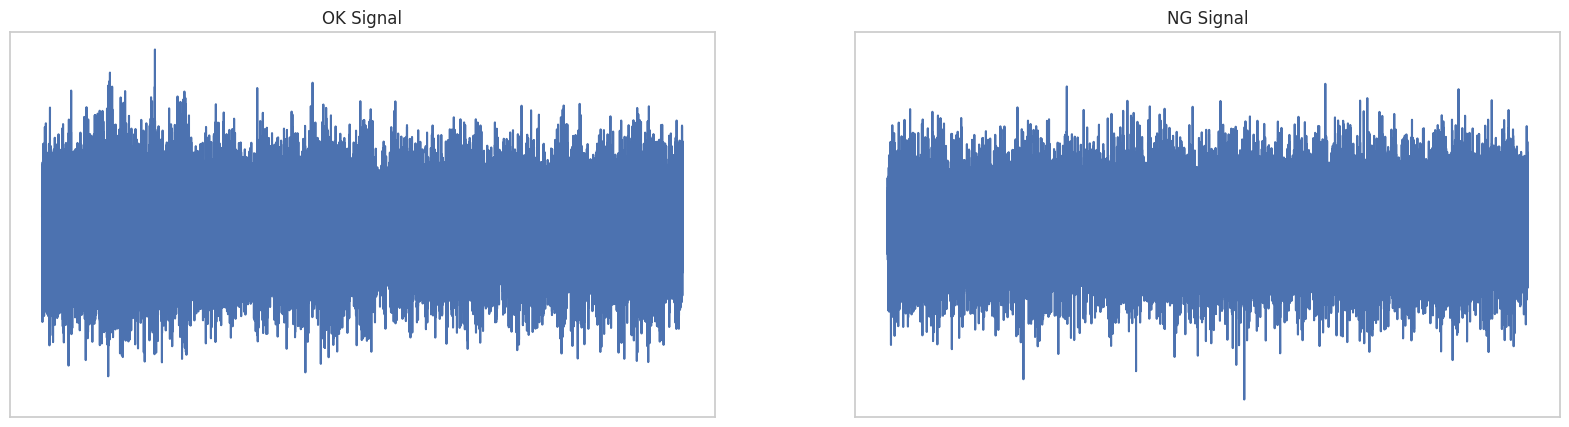

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False,
                        sharey=True, figsize=(20,5))

axes[0].set_title("OK Signal")
axes[0].plot(range(len(ok_signal)), ok_signal)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].set_title("NG Signal")
axes[1].plot(range(len(ng_signal)), ng_signal)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

### (3) Fourier Transform 비교

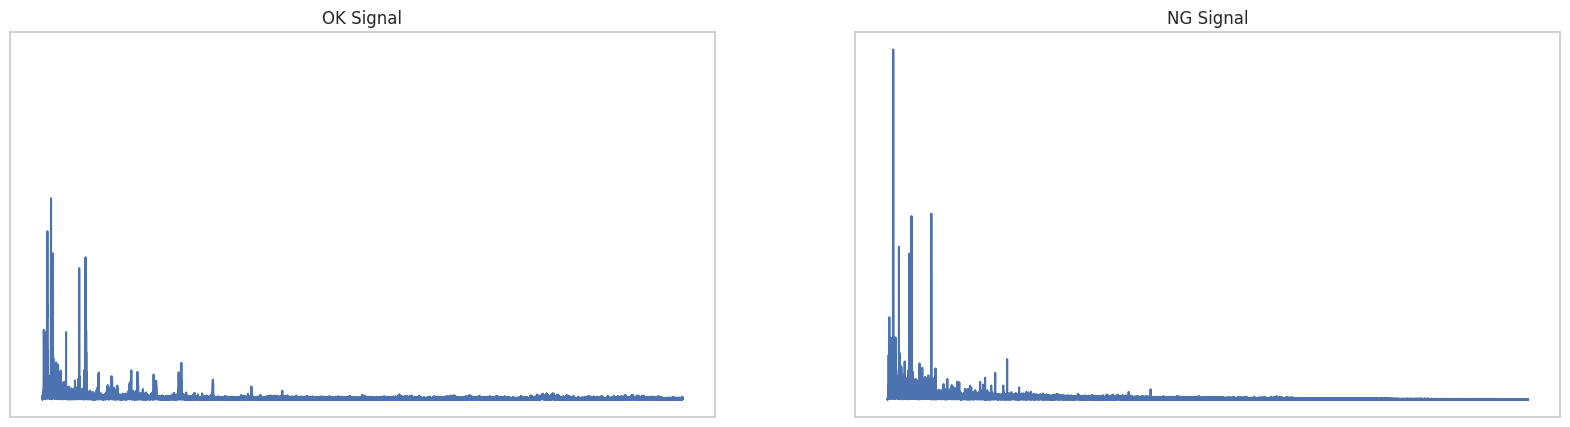

In [7]:
ok_fast_fourier_transf = np.fft.fft(ok_signal)
ok_magnitude = np.abs(ok_fast_fourier_transf)
ok_frequency = np.linspace(0, 16000, len(ok_magnitude))
ok_left_mag = ok_magnitude[:int(len(ok_magnitude)/2)]
ok_left_freq = ok_frequency[:int(len(ok_frequency)/2)]

ng_fast_fourier_transf = np.fft.fft(ng_signal)
ng_magnitude = np.abs(ng_fast_fourier_transf)
ng_frequency = np.linspace(0, 16000, len(ng_magnitude))
ng_left_mag = ng_magnitude[:int(len(ng_magnitude)/2)]
ng_left_freq = ng_frequency[:int(len(ng_frequency)/2)]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False,
                        sharey=True, figsize=(20,5))

axes[0].set_title("OK Signal")
axes[0].plot(ok_left_freq, ok_left_mag)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].set_title("NG Signal")
axes[1].plot(ng_left_freq, ng_left_mag)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

### (4) Mel Spectrogram 비교

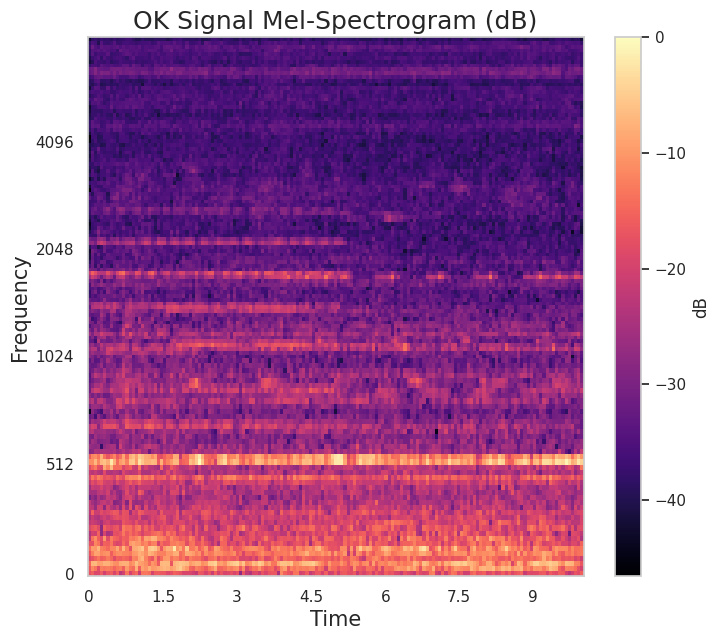

In [8]:
ok_mel_signal = librosa.feature.melspectrogram(y=ok_signal, sr=16000, hop_length=1024, n_fft=2048)
ok_spectrogram = np.abs(ok_mel_signal)
ok_power_to_db = librosa.power_to_db(ok_spectrogram, ref=np.max)
plt.figure(figsize=(8, 7))
librosa.display.specshow(ok_power_to_db, sr=16000, x_axis='time', y_axis='mel', cmap='magma', hop_length=1024)
plt.colorbar(label='dB')
plt.title('OK Signal Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

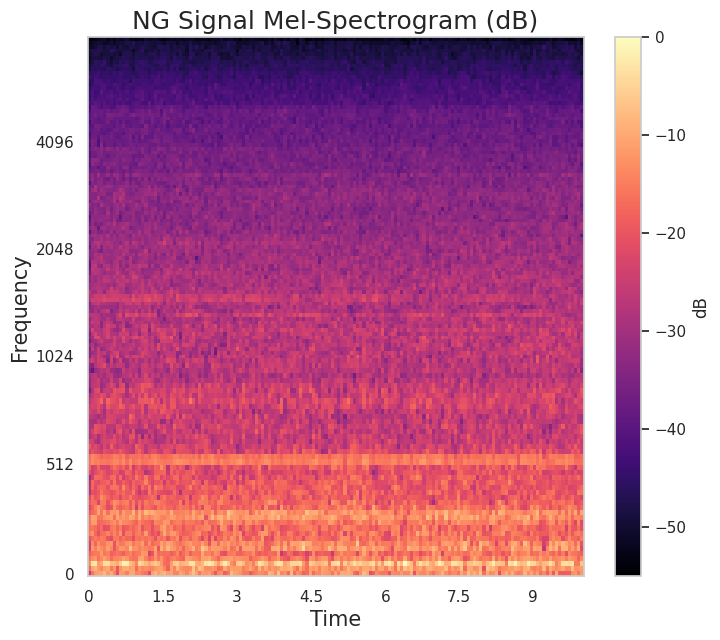

In [9]:
ng_mel_signal = librosa.feature.melspectrogram(y=ng_signal, sr=16000, hop_length=1024, n_fft=2048)
ng_spectrogram = np.abs(ng_mel_signal)
ng_power_to_db = librosa.power_to_db(ng_spectrogram, ref=np.max)
plt.figure(figsize=(8, 7))
librosa.display.specshow(ng_power_to_db, sr=16000, x_axis='time', y_axis='mel', cmap='magma', hop_length=1024)
plt.colorbar(label='dB')
plt.title('NG Signal Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

## 4. Experiment Setting

### (1) Train Test 분할

Class Imbalaance 문제를 최소화하기 위해서 아래와 같이 Train과 Test를 구성한다.  

- Train: OK = 400개  NG = 400개
- Test: OK = 100개  NG = 100개

In [105]:
np.random.seed(555)
train_ok_samples = np.random.choice(a=ok_files, size=900, replace=False)
train_ng_samples = np.random.choice(a=ng_files, size=900, replace=False)
test_ok_samples = np.random.choice(a=list(set(ok_files)- set(train_ok_samples)), size=100, replace=False)
test_ng_samples = np.random.choice(a=list(set(ng_files) - set(train_ng_samples)), size=100, replace=False)

train_files = [os.path.join("data/OK", fname) for fname in train_ok_samples] + [os.path.join("./data/NG", fname) for fname in train_ng_samples]
test_files = [os.path.join("data/OK", fname) for fname in test_ok_samples] + [os.path.join("./data/NG", fname) for fname in test_ng_samples]
train_y = np.array([0] * len(train_ok_samples) + [1] * len(train_ng_samples))
test_y = np.array([0] * len(test_ok_samples) + [1] * len(test_ng_samples))


### (2) Make Features

In [127]:
def mel_spectrogram(file_name):  
    signal, _ = librosa.load(file_name, 16000)
    spec=melspectrogram(y=signal, sr=16000, n_fft=1024,
                        hop_length=512, n_mels=128)
    spec= librosa.power_to_db(S=spec, ref=np.max)
    spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))
    spec = np.stack([np.mean(spec,1), np.min(spec,1), np.max(spec,1), np.std(spec,1)])
    return spec.reshape(-1)

In [128]:
train_feature = [mel_spectrogram(file_name) for file_name in train_files]
train_feature = np.vstack(train_feature)

test_feature = [mel_spectrogram(file_name) for file_name in test_files]
test_feature = np.vstack(test_feature)

/tmp/ipykernel_25205/7161428.py:2: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal, _ = librosa.load(file_name, 16000)


In [129]:
print("Train Feature: {}".format(train_feature.shape))
print("Test Feature: {}".format(test_feature.shape))


Train Feature: (1800, 512)
Test Feature: (200, 512)


## 5. FCN

### (1) Make DataLoader

In [130]:
class ConstructDataset(Dataset):
    def __init__(self, feature, y):
        self.feature = feature
        self.y = y
        
    def __len__(self):
        return len(self.feature)

    def __getitem__(self, index):

        feature = self.feature[index]
        y = self.y[index]
        return {'feature': feature, 'y': y}

In [131]:
train_dataset = ConstructDataset(train_feature, train_y)
test_dataset = ConstructDataset(test_feature, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### (2) Parameters 설정

In [285]:
EPOCH = 100
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-6
n_features = train_feature.shape[1]

result_path = "./Experiment"
os.makedirs(result_path, exist_ok = True)

### (3) FCN Model - 2 Layers

In [354]:
class FCN_model_2layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        #self.hidden2 = nn.Linear(256, 128)
        #self.hidden3 = nn.Linear(128, 64)
        #self.hidden4 = nn.Linear(64, 32)
        #self.hidden5 = nn.Linear(32, 16)
        #self.hidden6 = nn.Linear(16, 8)
        #self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        #x = torch.nn.functional.relu(self.hidden2(x))
        #x = torch.nn.functional.relu(self.hidden3(x))
        #x = torch.nn.functional.relu(self.hidden4(x))
        #x = torch.nn.functional.relu(self.hidden5(x))
        #x = torch.nn.functional.relu(self.hidden6(x))
        #x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [367]:
fcn_model_2layers = FCN_model_2layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_2layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(fcn_model_2layers.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [368]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_2layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_2layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_2layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_2layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_2layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_2layers_model.pth'))

Epoch 1 	 Training Loss: 0.7843881043894537 	 Training Acc: 0.4855555593967438 		 Validation Loss: 0.7170326560735703 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.703297890465835 	 Training Acc: 0.5111111402511597 		 Validation Loss: 0.6774486750364304 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.6900097768882225 	 Training Acc: 0.5250000357627869 		 Validation Loss: 0.7013726085424423 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6902254244376873 	 Training Acc: 0.5200000405311584 		 Validation Loss: 0.6939404457807541 	 Validation Acc: 0.5099999904632568
Validation Accuracy Increased(0.500000--->0.510000) 	 Saving The Model
Epoch 5 	 Training Loss: 0.6884171962738037 	 Training Acc: 0.5233333706855774 		 Validation Loss: 0.6847885102033615 	 Validation Acc: 0.5949999690055847
Validation Accuracy Increased(0.510000--->0.595000) 	 Saving The Model
Epoch 6 	 Training Loss: 0.6854664107848858 	 Training Acc

### (4) FCN Model - 4 Layers

In [364]:
class FCN_model_4layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        #self.hidden4 = nn.Linear(64, 32)
        #self.hidden5 = nn.Linear(32, 16)
        #self.hidden6 = nn.Linear(16, 8)
        #self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = torch.nn.functional.relu(self.hidden3(x))
        #x = torch.nn.functional.relu(self.hidden4(x))
        #x = torch.nn.functional.relu(self.hidden5(x))
        #x = torch.nn.functional.relu(self.hidden6(x))
        #x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [365]:
fcn_model_4layers = FCN_model_4layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_4layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(fcn_model_4layers.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [366]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_4layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_4layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_4layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_4layers_model.pth'))

Epoch 1 	 Training Loss: 0.7197755040793583 	 Training Acc: 0.4983333349227905 		 Validation Loss: 0.6806535124778748 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.6941131312271644 	 Training Acc: 0.4844444692134857 		 Validation Loss: 0.6904062628746033 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.6928376781529394 	 Training Acc: 0.5066666603088379 		 Validation Loss: 0.6953138560056686 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6938968876312519 	 Training Acc: 0.48777779936790466 		 Validation Loss: 0.6928159892559052 	 Validation Acc: 0.6150000095367432
Validation Accuracy Increased(0.500000--->0.615000) 	 Saving The Model
Epoch 5 	 Training Loss: 0.6930407593990194 	 Training Acc: 0.5044444799423218 		 Validation Loss: 0.6940827816724777 	 Validation Acc: 0.5
Epoch 6 	 Training Loss: 0.6928082272924226 	 Training Acc: 0.5099999904632568 		 Validation Loss: 0.6937286853790283 	 Validation Acc: 0.5149

### (5) FCN Model - 6 Layers

In [320]:
class FCN_model_6layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.hidden5 = nn.Linear(32, 16)
        #self.hidden6 = nn.Linear(16, 8)
        #self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = torch.nn.functional.relu(self.hidden3(x))
        x = torch.nn.functional.relu(self.hidden4(x))
        x = torch.nn.functional.relu(self.hidden5(x))
        #x = torch.nn.functional.relu(self.hidden6(x))
        #x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [323]:
fcn_model_6layers = FCN_model_6layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_6layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(fcn_model_6layers.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [324]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_6layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_6layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_6layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_6layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_6layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_6layers_model.pth'))

Epoch 1 	 Training Loss: 0.6955558822072786 	 Training Acc: 0.48500001430511475 		 Validation Loss: 0.6983678042888641 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.6943112406237372 	 Training Acc: 0.4927777945995331 		 Validation Loss: 0.702096477150917 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.693619639709078 	 Training Acc: 0.5 		 Validation Loss: 0.6944818943738937 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6936655003449013 	 Training Acc: 0.5044444799423218 		 Validation Loss: 0.694049060344696 	 Validation Acc: 0.4949999749660492
Epoch 5 	 Training Loss: 0.6930762611586472 	 Training Acc: 0.5044444799423218 		 Validation Loss: 0.6943298876285553 	 Validation Acc: 0.5
Epoch 6 	 Training Loss: 0.6934683816186313 	 Training Acc: 0.5 		 Validation Loss: 0.6967572122812271 	 Validation Acc: 0.5
Epoch 7 	 Training Loss: 0.6931254000499331 	 Training Acc: 0.5005555748939514 		 Validation Loss: 0.69356

### (6) FCN Model - 8 Layers

In [325]:
class FCN_model_8layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.hidden5 = nn.Linear(32, 16)
        self.hidden6 = nn.Linear(16, 8)
        self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = torch.nn.functional.relu(self.hidden3(x))
        x = torch.nn.functional.relu(self.hidden4(x))
        x = torch.nn.functional.relu(self.hidden5(x))
        x = torch.nn.functional.relu(self.hidden6(x))
        x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [330]:
fcn_model_8layers = FCN_model_8layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_8layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(fcn_model_8layers.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [331]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_8layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_6layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_8layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_8layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_8layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_8layers_model.pth'))

Epoch 1 	 Training Loss: 0.692770257078368 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.6927875855873371 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.6927915236045574 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6927627715571173 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Epoch 5 	 Training Loss: 0.6927939571183304 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Epoch 6 	 Training Loss: 0.6927982465974216 	 Training Acc: 0.5666666626930237 		 Validation Loss: 0.7405128628015518 	 Validation Acc: 0.5
Epoch 7 	 Training Loss: 0.692787937049208 	 Training Acc: 0.5666666626930237 		 Validatio

### (7) FCN Model - 4 Layers,  Optimizer: SGD

In [333]:
class FCN_model_4layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        #self.hidden4 = nn.Linear(64, 32)
        #self.hidden5 = nn.Linear(32, 16)
        #self.hidden6 = nn.Linear(16, 8)
        #self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = torch.nn.functional.relu(self.hidden3(x))
        #x = torch.nn.functional.relu(self.hidden4(x))
        #x = torch.nn.functional.relu(self.hidden5(x))
        #x = torch.nn.functional.relu(self.hidden6(x))
        #x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [336]:
fcn_model_4layers = FCN_model_4layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_4layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adadelta(fcn_model_4layers.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [337]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_4layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_4layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_4layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_4layers_model_Adadelta.pth'))

Epoch 1 	 Training Loss: 0.6932965105977552 	 Training Acc: 0.5 		 Validation Loss: 0.6907137185335159 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.6931728412365091 	 Training Acc: 0.5 		 Validation Loss: 0.6908135116100311 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.6931748616284338 	 Training Acc: 0.5 		 Validation Loss: 0.6909160315990448 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6931349121291062 	 Training Acc: 0.5 		 Validation Loss: 0.6909800469875336 	 Validation Acc: 0.5
Epoch 5 	 Training Loss: 0.6930449995501288 	 Training Acc: 0.5 		 Validation Loss: 0.6909965723752975 	 Validation Acc: 0.5
Epoch 6 	 Training Loss: 0.6930350969577658 	 Training Acc: 0.5 		 Validation Loss: 0.6910350024700165 	 Validation Acc: 0.5
Epoch 7 	 Training Loss: 0.6931462616756044 	 Training Acc: 0.5 		 Validation Loss: 0.6911814659833908 	 Validation Acc: 0.5
Epoch 8 	 Training Loss: 0.6931551612656692 	 Training

### (8) FCN Model - 4 Layers,  Optimizer: SGD

In [338]:
class FCN_model_4layers(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        #self.hidden4 = nn.Linear(64, 32)
        #self.hidden5 = nn.Linear(32, 16)
        #self.hidden6 = nn.Linear(16, 8)
        #self.hidden7 = nn.Linear(8, 4)
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = torch.nn.functional.relu(self.hidden3(x))
        #x = torch.nn.functional.relu(self.hidden4(x))
        #x = torch.nn.functional.relu(self.hidden5(x))
        #x = torch.nn.functional.relu(self.hidden6(x))
        #x = torch.nn.functional.relu(self.hidden7(x))
        x = self.sigmoid(self.output(x))
        return x

In [339]:
fcn_model_4layers = FCN_model_4layers(input_dim = n_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fcn_model_4layers.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(fcn_model_4layers.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [340]:
min_valid_acc = 0

# training

for e in range(EPOCH):
    train_loss = 0.0
    correct = 0
    total = 0
    fcn_model_4layers.train()     # Optional when not using Model Specific layer
    for data in train_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        optimizer.zero_grad()
        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    fcn_model_4layers.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader:
        if torch.cuda.is_available():
            feature, labels = data['feature'].float().to(device), data['y'].float().to(device)

        target = fcn_model_4layers(feature)
        loss = criterion(target[:,0],labels)
        valid_loss += loss.item()
        preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
        correct += (preicted == labels).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Validation Loss: {valid_loss / len(test_dataloader)} \t Validation Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Accuracy Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(fcn_model_4layers.state_dict(), os.path.join(result_path, 'Best_fcn_model_4layers_model_SGD.pth'))

Epoch 1 	 Training Loss: 0.6949156214450968 	 Training Acc: 0.5 		 Validation Loss: 0.7064852714538574 	 Validation Acc: 0.5
Validation Accuracy Increased(0.000000--->0.500000) 	 Saving The Model
Epoch 2 	 Training Loss: 0.6947196249304146 	 Training Acc: 0.5 		 Validation Loss: 0.7039236426353455 	 Validation Acc: 0.5
Epoch 3 	 Training Loss: 0.6940021350465971 	 Training Acc: 0.5 		 Validation Loss: 0.7021332085132599 	 Validation Acc: 0.5
Epoch 4 	 Training Loss: 0.6939650034082347 	 Training Acc: 0.5 		 Validation Loss: 0.7003494203090668 	 Validation Acc: 0.5
Epoch 5 	 Training Loss: 0.6936836181015804 	 Training Acc: 0.5 		 Validation Loss: 0.6989651322364807 	 Validation Acc: 0.5
Epoch 6 	 Training Loss: 0.6935093402862549 	 Training Acc: 0.5 		 Validation Loss: 0.6977827250957489 	 Validation Acc: 0.5
Epoch 7 	 Training Loss: 0.6930952462656744 	 Training Acc: 0.5 		 Validation Loss: 0.6973970383405685 	 Validation Acc: 0.5
Epoch 8 	 Training Loss: 0.6930873394012451 	 Training

## 6. Test Performance

### (1) 레이어 수 비교

#### - 2 Layers

In [378]:
fcn_model_2layers.load_state_dict(torch.load("Experiment/Best_fcn_model_2layers_model.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_2layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

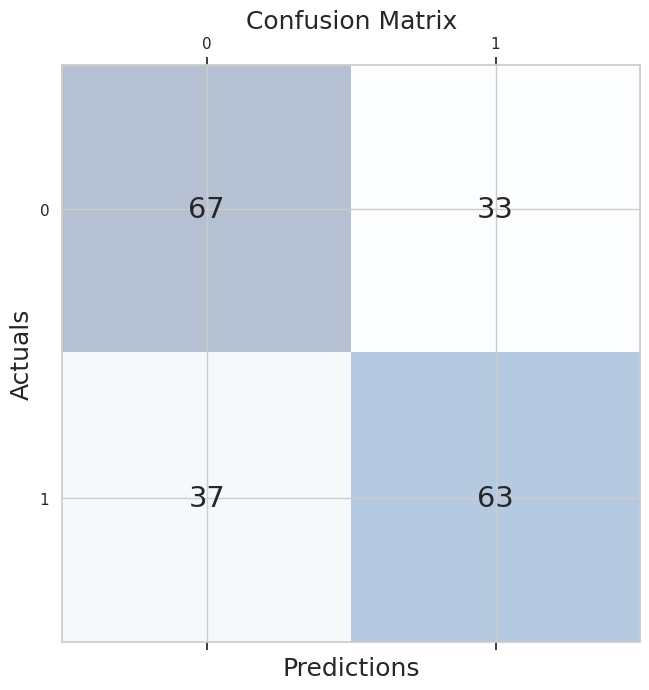

In [379]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [380]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.65
Test Precision: 0.65625
Test Recall: 0.63
Test F1 Score: 0.6428571428571429


#### - 4 Layer

In [381]:
fcn_model_4layers.load_state_dict(torch.load("Experiment/Best_fcn_model_4layers_model.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_4layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

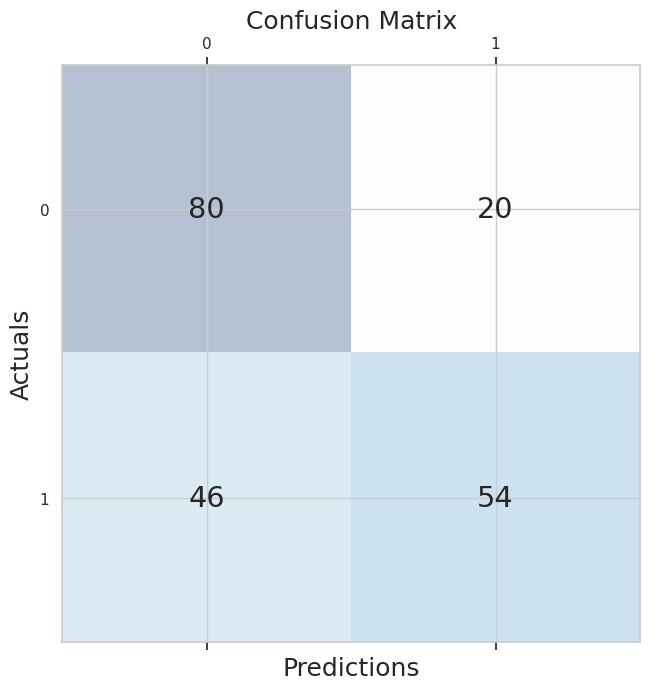

In [382]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [383]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.67
Test Precision: 0.7297297297297297
Test Recall: 0.54
Test F1 Score: 0.6206896551724138


#### - 6 Layers

In [384]:
fcn_model_6layers.load_state_dict(torch.load("Experiment/Best_fcn_model_6layers_model.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_6layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

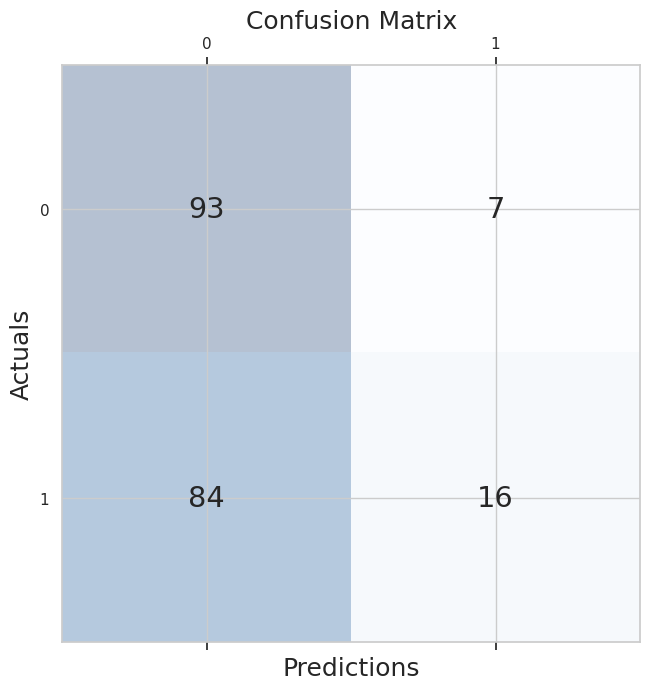

In [385]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [386]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.545
Test Precision: 0.6956521739130435
Test Recall: 0.16
Test F1 Score: 0.2601626016260163


#### - 8 Layers

In [387]:
fcn_model_8layers.load_state_dict(torch.load("Experiment/Best_fcn_model_8layers_model.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_8layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

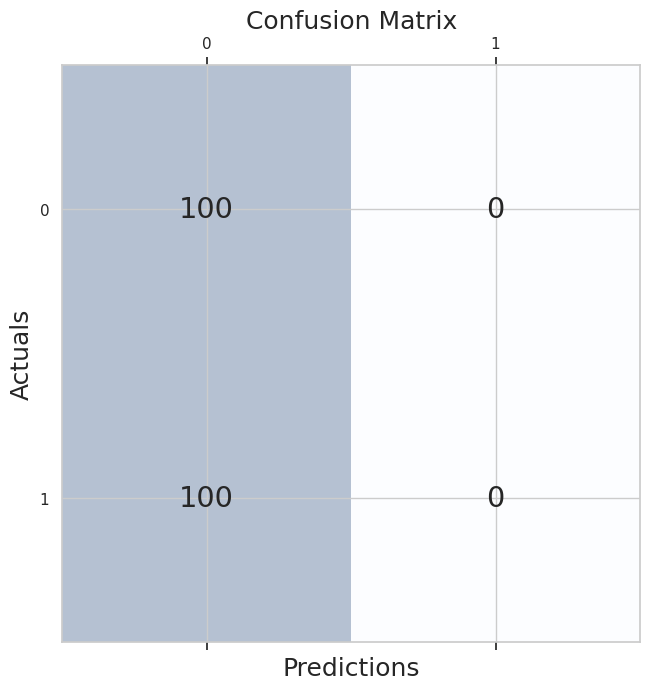

In [388]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [389]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.5
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0


/home/jongwook95.lee/miniforge3/envs/audio_classification/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### (2) Optimizer 비교

#### - Adadelta

In [390]:
fcn_model_4layers.load_state_dict(torch.load("Experiment/Best_fcn_model_4layers_model_Adadelta.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_4layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

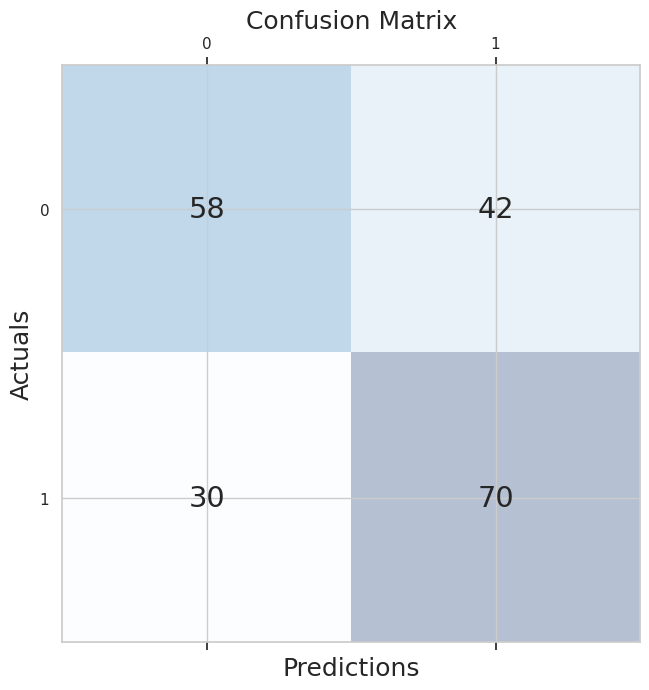

In [391]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [392]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.64
Test Precision: 0.625
Test Recall: 0.7
Test F1 Score: 0.6603773584905661


#### - SGD

In [393]:
fcn_model_4layers.load_state_dict(torch.load("Experiment/Best_fcn_model_4layers_model_SGD.pth"))
predicted_list = []
true_y_list = []

for data in test_dataloader:
    if torch.cuda.is_available():
        feature, labels = data['feature'].float().to(device), data['y'].float().to(device)
    target = fcn_model_4layers(feature)
    preicted = torch.as_tensor((target[:,0] - 0.5) > 0, dtype=torch.int32) 
    predicted_list.append(preicted.detach().cpu().numpy())
    true_y_list.append(labels.detach().cpu().numpy())

predicted_list = np.hstack(predicted_list)
true_y_list = np.hstack(true_y_list)

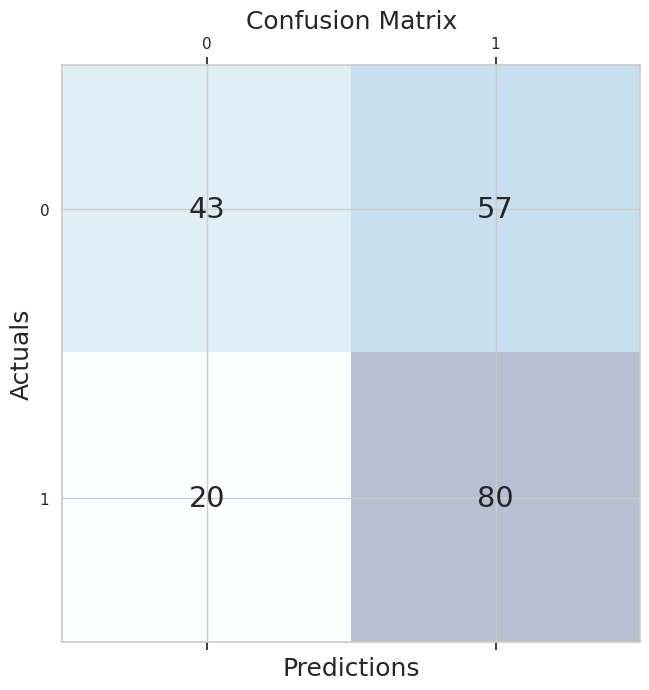

In [394]:
conf_matrix = confusion_matrix(y_true=true_y_list, y_pred=predicted_list)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [395]:
print("Test Accuracy: {}".format(accuracy_score(true_y_list, predicted_list)))
print("Test Precision: {}".format(precision_score(true_y_list, predicted_list)))
print("Test Recall: {}".format(recall_score(true_y_list, predicted_list)))
print("Test F1 Score: {}".format(f1_score(true_y_list, predicted_list)))

Test Accuracy: 0.615
Test Precision: 0.583941605839416
Test Recall: 0.8
Test F1 Score: 0.6751054852320675
